### Train model based on the different samples



Use same strategy as in the annomatic paper.

Test on BABE


In [1]:
!pip install vendi_score

import logging
import warnings
import os
import pandas as pd
import numpy as np
from vendi_score import vendi
import torch
import transformers
from datasets import Dataset,load_dataset
from torch.utils.data import DataLoader
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DataCollatorWithPadding,
    EarlyStoppingCallback,
    Trainer,
    TrainingArguments,
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    f1_score,
    matthews_corrcoef,
    precision_score,
    recall_score,
    roc_auc_score,
)

transformers.logging.set_verbosity(transformers.logging.ERROR)
logging.disable(logging.ERROR)
warnings.filterwarnings("ignore", category=FutureWarning)

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for vendi_score: filename=vendi_score-0.0.3-py3-none-any.whl size=13316 sha256=a6f890a8646f8605b4cf9178167da288c0b711afcadefc051b29911041578222
  Stored in directory: /root/.cache/pip/wheels/61/3e/72/6111f6ae4d7517f7d29a0bb1699bf6ea43ed48ff96bb10d723
Successfully built vendi_score


In [2]:
# Load subsamples
sampled_dfs = {}

samples_folder = "/kaggle/input/dirichlet-source-party/subsamples"

for filename in os.listdir(samples_folder):
    if filename.endswith(".csv"):
        sample_name = filename.split(".")[0]
        sampled_dfs[sample_name] = pd.read_csv(os.path.join(samples_folder, filename))



# Display the keys of the sampled_dfs dictionary to verify the loaded subsamples
print(sampled_dfs.keys())

dict_keys(['alpha_10_idx_2', 'alpha_10_idx_3', 'alpha_1_idx_1', 'alpha_100_idx_3', 'alpha_10_idx_1', 'alpha_1000_idx_1', 'alpha_0_01_idx_3', 'alpha_1_idx_2', 'alpha_100_idx_2', 'alpha_inf_idx_2', 'alpha_100_idx_1', 'alpha_inf_idx_3', 'alpha_1000_idx_2', 'alpha_0_1_idx_1', 'alpha_0_01_idx_2', 'alpha_0_01_idx_1', 'alpha_0_1_idx_3', 'alpha_inf_idx_1', 'alpha_1_idx_3', 'alpha_1000_idx_3', 'alpha_0_1_idx_2'])


In [3]:
# Define Vendi Score function for diversity measure

def vs_source(df):
    features= df[['reliability', 'bias']].to_numpy()
    distances= np.sqrt(np.sum((features[:, np.newaxis] - features[np.newaxis, :]) ** 2, axis=-1))
    similarity_matrix = 1 / (1 + distances)

    vs = vendi.score_K(similarity_matrix)
    return vs



for name, df in sampled_dfs.items():
    # VS score
    print(vs_source(df))

42.36204969411056
41.89943211470747
29.0637241180812
42.23270525836314
40.77482204321009
42.46382987405022
8.810501531372692
26.742814429553615
42.372671618394776
43.77923979483535
41.0264544016782
42.311102025241894
40.88155173576922
8.751802312073396
8.42884902837399
12.809857865035188
18.217655212962526
42.12518033568915
29.666980490335277
41.61326489845395
21.20190529122967


Fine-tune Roberta model on the different subsamples

In [4]:
# Definitions

base_model = "roberta-base"
device = (
    torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
)

# Prepare Model
model = AutoModelForSequenceClassification.from_pretrained(
    base_model,
    num_labels=2,
)
tokenizer = AutoTokenizer.from_pretrained(base_model)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer) # dynammically pads sequences to the length of the longest sequence in each batch


# the pretrained head of roberta is discarded and replaced with a randomly initialized classification head

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [5]:
# Define metrics
def compute_metrics_hf(preds):
    """computes F1 score and accuracy over dataset
    Args:
        model (any type): model for evaluation
        testing_dataloader (huggingface dataset): self explained
    Returns:
        dict
    """
    y_pred=preds.predictions
    y_true=preds.label_ids
    y_pred=y_pred.argmax(axis=1)
    mcc=matthews_corrcoef(y_true,y_pred)
    f1=f1_score(y_true,y_pred)
    precision=precision_score(y_true,y_pred)
    recall=recall_score(y_true,y_pred)
    roc_auc=roc_auc_score(y_true,y_pred)
    return{
        "mcc":mcc,
        "f1":f1,
        "precision":precision,
        "recall":recall,
        "roc_auc":roc_auc,
    }

def compute_metrics(testing_dataloader,model):
    """computes F1 score and accuracy over dataset
    Args:
        model (any type): model for evaluation
        testing_dataloader (huggingface dataset): self explained
    Returns:
        dict
    """
    y_true=[]
    y_pred=[]
    model.eval()
    for batch in testing_dataloader:
        batch={k:v.to(model.device)for k,v in batch.items()}
        with torch.no_grad():
            outputs=model(**batch)
        logits=outputs.logits
        predictions=torch.argmax(logits,dim=-1)
        y_true.extend(batch["labels"].tolist())
        y_pred.extend(predictions.tolist())
    mcc=matthews_corrcoef(y_true,y_pred)
    f1=f1_score(y_true,y_pred)
    precision=precision_score(y_true,y_pred)
    recall=recall_score(y_true,y_pred)
    roc_auc=roc_auc_score(y_true,y_pred)
    return{
        "mcc":mcc,
        "f1":f1,
        "precision":precision,
        "recall":recall,
        "roc_auc":roc_auc,
    }


In [7]:
# metrics and vs scores
results_list=[]

def tokenize_function(examples):
    return tokenizer(examples['text'], padding=True, truncation=True, max_length=128, return_tensors="pt")

# Import BABE for test sets
babe= load_dataset("mediabiasgroup/BABE")["train"].to_pandas()

dev_df, test_df = train_test_split(babe,test_size=0.67,random_state=42,stratify=babe['label'])
dev_df = Dataset.from_pandas(dev_df).map(tokenize_function, batched=True)
test_df = Dataset.from_pandas(test_df).map(tokenize_function, batched=True)

dev_df.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_df.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])



# loop through each sampled df and evaluate the model
for name,df in sampled_dfs.items():
    # VS score
    df_vs= vs_source(df)
    
    # Convert to hf datasets
    train_df=Dataset.from_pandas(df).map(tokenize_function,batched=True)
    train_df.set_format(type='torch',columns=['input_ids','attention_mask','label'])

    
    training_args=TrainingArguments(
        output_dir="./checkpoints",
        per_device_eval_batch_size=32,
        per_device_train_batch_size=32,
        num_train_epochs=3,
        save_total_limit=3,
        evaluation_strategy="steps",
        logging_steps=50,
        eval_steps=50,
        save_steps=50,
        disable_tqdm=False,
        weight_decay=0.05,
        learning_rate=2e-5,
        # run_name="annomatic_test_eval",
        metric_for_best_model="eval_loss",
        save_strategy="steps",
        load_best_model_at_end=True,
        remove_unused_columns=False,
    )

    # Trainer initialization
    trainer=Trainer(
        model,
        training_args,
        train_dataset=train_df,
        eval_dataset=dev_df,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics_hf,
        data_collator=data_collator,
        callbacks=[
            EarlyStoppingCallback(
                early_stopping_patience=5,
                early_stopping_threshold=0.0,
            ),
        ],
    )

    # Train the model
    trainer.train()
    
    # Evaluate on the test set
    eval_dataloader=DataLoader(
        test_df,
        batch_size=32,
        collate_fn=data_collator,
    )
    
    metrics=compute_metrics(eval_dataloader,model)
    metrics['vs']=df_vs  # Add the vs score to the metrics
    metrics['subsample']=name  # Add the df name   
    results_list.append(metrics)


Map:   0%|          | 0/1029 [00:00<?, ? examples/s]

Map:   0%|          | 0/2092 [00:00<?, ? examples/s]

Map:   0%|          | 0/2998 [00:00<?, ? examples/s]

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss,Mcc,F1,Precision,Recall,Roc Auc
50,0.607800,0.413034,0.627590,0.835509,0.834783,0.836237,0.813723
100,0.417300,0.394982,0.645932,0.842382,0.846831,0.837979,0.823385


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Map:   0%|          | 0/2999 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss,Mcc,F1,Precision,Recall,Roc Auc
50,0.440900,0.388591,0.620889,0.830255,0.838366,0.822300,0.811150
100,0.319500,0.429888,0.632372,0.820465,0.880240,0.768293,0.818212


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Map:   0%|          | 0/2998 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss,Mcc,F1,Precision,Recall,Roc Auc
50,0.429500,0.402447,0.616734,0.833333,0.822034,0.844948,0.807089
100,0.301900,0.488229,0.604703,0.809963,0.860784,0.764808,0.804382


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Map:   0%|          | 0/2998 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss,Mcc,F1,Precision,Recall,Roc Auc
50,0.407600,0.402955,0.620334,0.836457,0.818333,0.855401,0.807920
100,0.284700,0.451307,0.633519,0.828959,0.862524,0.797909,0.818735


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Map:   0%|          | 0/2997 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss,Mcc,F1,Precision,Recall,Roc Auc
50,0.421800,0.417259,0.596184,0.835703,0.764451,0.921603,0.781681
100,0.275700,0.436230,0.643329,0.838938,0.852518,0.825784,0.822782


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Map:   0%|          | 0/2998 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss,Mcc,F1,Precision,Recall,Roc Auc
50,0.410200,0.375317,0.642410,0.844635,0.832487,0.857143,0.819780
100,0.277600,0.418805,0.622968,0.830986,0.839858,0.822300,0.812249


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Map:   0%|          | 0/2999 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss,Mcc,F1,Precision,Recall,Roc Auc
50,0.380000,0.401402,0.623586,0.844408,0.789394,0.907666,0.801085
100,0.241900,0.486680,0.616650,0.838602,0.802548,0.878049,0.802761


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Map:   0%|          | 0/2997 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss,Mcc,F1,Precision,Recall,Roc Auc
50,0.382300,0.395819,0.638325,0.846605,0.815832,0.879791,0.814621
100,0.246000,0.455108,0.628189,0.841216,0.816393,0.867596,0.810721


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Map:   0%|          | 0/2997 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss,Mcc,F1,Precision,Recall,Roc Auc
50,0.362400,0.377101,0.653761,0.835165,0.880309,0.794425,0.829081
100,0.237800,0.425663,0.654157,0.839640,0.869403,0.811847,0.829000


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss,Mcc,F1,Precision,Recall,Roc Auc
50,0.328800,0.356982,0.666304,0.854436,0.844974,0.864111,0.832056
100,0.201400,0.480007,0.654765,0.848485,0.843373,0.853659,0.826829


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Map:   0%|          | 0/2997 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss,Mcc,F1,Precision,Recall,Roc Auc
50,0.349600,0.394987,0.661672,0.849387,0.853873,0.844948,0.831265
100,0.206800,0.492422,0.665047,0.848539,0.863063,0.834495,0.833731


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss,Mcc,F1,Precision,Recall,Roc Auc
50,0.331700,0.357621,0.676317,0.858377,0.851027,0.865854,0.837322
100,0.194500,0.516598,0.665993,0.850615,0.858156,0.843206,0.833691


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Map:   0%|          | 0/2998 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss,Mcc,F1,Precision,Recall,Roc Auc
50,0.335900,0.433694,0.642578,0.818613,0.899791,0.750871,0.822688
100,0.207100,0.485820,0.641350,0.832579,0.866290,0.801394,0.822675


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Map:   0%|          | 0/2999 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss,Mcc,F1,Precision,Recall,Roc Auc
50,0.372700,0.380144,0.642410,0.844635,0.832487,0.857143,0.819780
100,0.242700,0.433923,0.648406,0.842568,0.850799,0.834495,0.824940


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Map:   0%|          | 0/2999 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss,Mcc,F1,Precision,Recall,Roc Auc
50,0.255700,0.453339,0.650704,0.843034,0.853571,0.832753,0.826266
100,0.131500,0.611868,0.624303,0.838160,0.820000,0.857143,0.809890


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Map:   0%|          | 0/2999 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss,Mcc,F1,Precision,Recall,Roc Auc
50,0.355900,0.428586,0.620386,0.836177,0.819398,0.853659,0.808148
100,0.212800,0.524419,0.624234,0.838710,0.817881,0.860627,0.809434


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Map:   0%|          | 0/2999 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss,Mcc,F1,Precision,Recall,Roc Auc
50,0.257200,0.436021,0.642222,0.845431,0.829146,0.862369,0.819097
100,0.136200,0.545084,0.618809,0.839834,0.801902,0.881533,0.803404


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss,Mcc,F1,Precision,Recall,Roc Auc
50,0.291500,0.455623,0.613075,0.838017,0.797170,0.883275,0.799879
100,0.164000,0.521096,0.620600,0.835334,0.822635,0.848432,0.808831


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Map:   0%|          | 0/2998 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss,Mcc,F1,Precision,Recall,Roc Auc
50,0.300600,0.413132,0.634927,0.830325,0.861423,0.801394,0.819378
100,0.161800,0.542608,0.624238,0.840067,0.812704,0.869338,0.808295


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Map:   0%|          | 0/2997 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss,Mcc,F1,Precision,Recall,Roc Auc
50,0.288200,0.492392,0.644903,0.815385,0.909871,0.738676,0.823184
100,0.143800,0.525092,0.642846,0.839506,0.850000,0.829268,0.822326


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Map:   0%|          | 0/2999 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss,Mcc,F1,Precision,Recall,Roc Auc
50,0.320600,0.402045,0.644182,0.846416,0.829431,0.864111,0.819968
100,0.168500,0.545562,0.610266,0.833755,0.808511,0.860627,0.801742


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [ ]:
results_df = pd.DataFrame(results_list)
results_df = results_df[['subsample'] + [col for col in results_df.columns if col != 'subsample']]

results['alpha'] = results['subsample'].str.extract(r'alpha_([\d_]+)').replace('_', '.', regex=True)
results_df.to_csv("results_df.csv", index=False)


# df['alpha'] = df['name'].str.extract(r'alpha_([\d_]+)').replace('_', '.', regex=True)


# styled_df = test.style \
#     .highlight_max(color='lightgreen', axis=0, subset=results_df.columns.difference(['subsample'])) \
#     .highlight_min(color='lightcoral', axis=0, subset=results_df.columns.difference(['subsample']))



# # Display the styled DataFrame

# # styled_df.sort_values(by=["vs"])
# styled_df


In [21]:
results_df = pd.DataFrame(results_list)
results_df = results_df[['subsample'] + [col for col in results_df.columns if col != 'subsample']]

results_df['alpha'] = results_df['subsample'].str.extract(r'alpha_(.*?)_idx').replace('_', '.', regex=True)
results_df['alpha'] = results_df['alpha'].replace(np.inf, float('inf'))

results_df = results_df.sort_values(by='alpha', ascending=True)

results_df.to_csv("results_df.csv", index=False)

results_df

,subsample,mcc,f1,precision,recall,roc_auc,vs,alpha
15,alpha_0_01_idx_1,0.664689,0.855225,0.837305,0.873928,0.830053,12.809858,0.01
14,alpha_0_01_idx_2,0.669845,0.851691,0.861404,0.842196,0.835785,8.428849,0.01
6,alpha_0_01_idx_3,0.623381,0.843750,0.791729,0.903087,0.801976,8.810502,0.01
20,alpha_0_1_idx_2,0.657920,0.851852,0.836364,0.867925,0.827051,21.201905,0.1
16,alpha_0_1_idx_3,0.662145,0.852292,0.843697,0.861063,0.830100,18.217655,0.1
13,alpha_0_1_idx_1,0.654072,0.849916,0.835821,0.864494,0.825336,8.751802,0.1
18,alpha_1_idx_3,0.670253,0.843666,0.885849,0.805317,0.837324,29.666980,1
2,alpha_1_idx_1,0.632944,0.839695,0.830537,0.849057,0.815457,29.063724,1
7,alpha_1_idx_2,0.641333,0.847331,0.818545,0.878216,0.816538,26.742814,1
0,alpha_10_idx_2,0.629546,0.836892,0.833333,0.840480,0.814409,42.362050,10


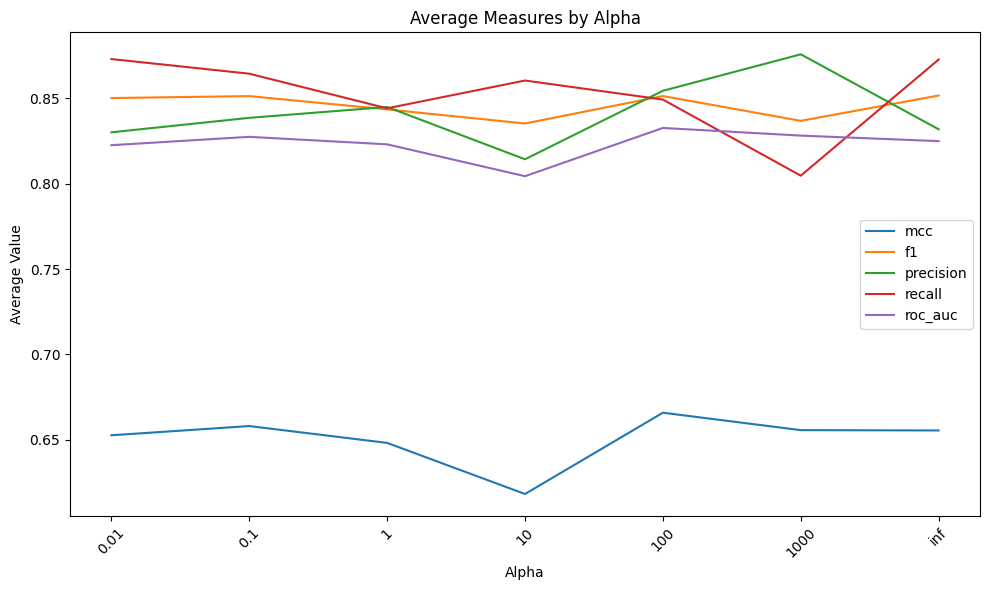

In [25]:
import matplotlib.pyplot as plt

# Group by 'alpha' and calculate the mean for each measure
avg_measures = results_df.groupby('alpha')[['mcc', 'f1', 'precision', 'recall', 'roc_auc']].mean()

# Plot the results
plt.figure(figsize=(10, 6))

# Plot each measure
for measure in avg_measures.columns:
    plt.plot(avg_measures.index, avg_measures[measure], label=measure)

# Set labels and title
plt.xlabel('Alpha')
plt.ylabel('Average Value')
plt.title('Average Measures by Alpha')

# Add legend
plt.legend()

# Display the plot
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()       # Adjust layout to prevent overlap
plt.show()